In [88]:
# Dataclass Preparation
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import dlib
from imutils import face_utils
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import numpy as np
import os
from torch.utils.data import Dataset
import torch
from PIL import Image
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from glob import glob
import segmentation_models_pytorch as smp
import torch.nn.functional as F
import cv2
import time 
import mediapipe
from torchvision import transforms
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import albumentations as A
from albumentations.pytorch import ToTensorV2
import glob
from torchvision.models.feature_extraction import create_feature_extractor
device =torch.device("cuda:1" if torch.cuda.is_available() else "cpu")




In [11]:
# Load the Model 
model_path = "/home/user/Documents/LuminEye/LuminEye/LuminEye-Experiments/U2net/U2NET_MULTICLASS_IMG_256_DIC_batch_8/Miche_model_2023_04_11_22:14:26_val_iou0.900.pt"


    

In [12]:
model = torch.load(model_path,map_location=device)

In [13]:
for name,param in model.named_parameters():
    print(name)

stage1.rebnconvin.conv_s1.weight
stage1.rebnconvin.conv_s1.bias
stage1.rebnconvin.bn_s1.weight
stage1.rebnconvin.bn_s1.bias
stage1.rebnconv1.conv_s1.weight
stage1.rebnconv1.conv_s1.bias
stage1.rebnconv1.bn_s1.weight
stage1.rebnconv1.bn_s1.bias
stage1.rebnconv2.conv_s1.weight
stage1.rebnconv2.conv_s1.bias
stage1.rebnconv2.bn_s1.weight
stage1.rebnconv2.bn_s1.bias
stage1.rebnconv3.conv_s1.weight
stage1.rebnconv3.conv_s1.bias
stage1.rebnconv3.bn_s1.weight
stage1.rebnconv3.bn_s1.bias
stage1.rebnconv4.conv_s1.weight
stage1.rebnconv4.conv_s1.bias
stage1.rebnconv4.bn_s1.weight
stage1.rebnconv4.bn_s1.bias
stage1.rebnconv5.conv_s1.weight
stage1.rebnconv5.conv_s1.bias
stage1.rebnconv5.bn_s1.weight
stage1.rebnconv5.bn_s1.bias
stage1.rebnconv6.conv_s1.weight
stage1.rebnconv6.conv_s1.bias
stage1.rebnconv6.bn_s1.weight
stage1.rebnconv6.bn_s1.bias
stage1.rebnconv7.conv_s1.weight
stage1.rebnconv7.conv_s1.bias
stage1.rebnconv7.bn_s1.weight
stage1.rebnconv7.bn_s1.bias
stage1.rebnconv6d.conv_s1.weight
sta

In [21]:
list(model.children())[:11]

[RSU7(
   (rebnconvin): REBNCONV(
     (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu_s1): ReLU(inplace=True)
   )
   (rebnconv1): REBNCONV(
     (conv_s1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu_s1): ReLU(inplace=True)
   )
   (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
   (rebnconv2): REBNCONV(
     (conv_s1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu_s1): ReLU(inplace=True)
   )
   (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
   (rebnconv3): REBNCONV(
     (conv_s1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), pad

In [3]:
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision.models.feature_extraction import  get_graph_node_names

In [10]:
get_graph_node_names(model)

/home/user/mambaforge/envs/LuminEye/lib/python3.10/site-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


(['x',
  'stage1.rebnconvin.conv_s1',
  'stage1.rebnconvin.bn_s1',
  'stage1.rebnconvin.relu_s1',
  'stage1.rebnconv1.conv_s1',
  'stage1.rebnconv1.bn_s1',
  'stage1.rebnconv1.relu_s1',
  'stage1.pool1',
  'stage1.rebnconv2.conv_s1',
  'stage1.rebnconv2.bn_s1',
  'stage1.rebnconv2.relu_s1',
  'stage1.pool2',
  'stage1.rebnconv3.conv_s1',
  'stage1.rebnconv3.bn_s1',
  'stage1.rebnconv3.relu_s1',
  'stage1.pool3',
  'stage1.rebnconv4.conv_s1',
  'stage1.rebnconv4.bn_s1',
  'stage1.rebnconv4.relu_s1',
  'stage1.pool4',
  'stage1.rebnconv5.conv_s1',
  'stage1.rebnconv5.bn_s1',
  'stage1.rebnconv5.relu_s1',
  'stage1.pool5',
  'stage1.rebnconv6.conv_s1',
  'stage1.rebnconv6.bn_s1',
  'stage1.rebnconv6.relu_s1',
  'stage1.rebnconv7.conv_s1',
  'stage1.rebnconv7.bn_s1',
  'stage1.rebnconv7.relu_s1',
  'stage1.cat',
  'stage1.rebnconv6d.conv_s1',
  'stage1.rebnconv6d.bn_s1',
  'stage1.rebnconv6d.relu_s1',
  'stage1.getattr',
  'stage1.getitem',
  'stage1.interpolate',
  'stage1.cat_1',
  'stag

In [27]:
return_nodes = ['stage6.rebnconv1d.conv_s1']

feat_ext = create_feature_extractor(model,return_nodes=return_nodes)

/home/user/mambaforge/envs/LuminEye/lib/python3.10/site-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [32]:
tnsr = torch.randn(2,3,64,64).to(device)

In [39]:
class BBOX_ENCODER(nn.Module):
    def __init__(self,model_path):
        super().__init__()
        self.model = torch.load(model_path)
        layers = list(model.children())[:11]
        self.features = nn.Sequential(*layers)
        


        self.bb = nn.Sequential(nn.BatchNorm1d(512),
                                nn.Linear(512,256),
                                nn.ReLU(),
                                nn.Linear(256,2)
                                )

    def forward(self,x):

        x = self.features(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        
        x = x.view(x.shape[0],-1)

        return self.bb(x)


In [40]:
m_model = BBOX_ENCODER(model_path).to(device)

In [41]:
m_model(tnsr)

/home/user/mambaforge/envs/LuminEye/lib/python3.10/site-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


tensor([[-0.1747,  0.0067],
        [ 0.6045,  0.0500]], device='cuda:1', grad_fn=<AddmmBackward0>)

In [42]:
from torchvision.models.efficientnet import efficientnet_b3

In [43]:
model  = efficientnet_b3(weights=True)

/home/user/mambaforge/envs/LuminEye/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [50]:
list(model.children())[1]

AdaptiveAvgPool2d(output_size=1)

In [55]:
feature = list(model.children())[:1]

[Sequential(
   (0): Conv2dNormActivation(
     (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): SiLU(inplace=True)
   )
   (1): Sequential(
     (0): MBConv(
       (block): Sequential(
         (0): Conv2dNormActivation(
           (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
           (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (2): SiLU(inplace=True)
         )
         (1): SqueezeExcitation(
           (avgpool): AdaptiveAvgPool2d(output_size=1)
           (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
           (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
           (activation): SiLU(inplace=True)
           (scale_activation): Sigmoid()
         )
         (2): Conv2dNormActivation(
           (0): Conv2d(40, 24, kernel_siz

In [82]:
class BB_model(nn.Module):
    def __init__(self):
        super().__init__()
        efficientnet = efficientnet_b3(pretrained=True)
        
        layers = list(efficientnet.children())[:1]
        self.features1 = nn.Sequential(*layers)

    
        self.bb = nn.Sequential(nn.BatchNorm1d(1536),nn.Linear(1536,512),nn.ReLU(inplace=True),
                                nn.BatchNorm1d(512),nn.Linear(512,2))
        
    def forward(self,x):
        x = self.features1(x) #[1, 1536, 8, 8]
        x = F.relu(x)
        
        
        x = nn.AdaptiveAvgPool2d((1,1))(x) # [ 1,1536,1,1]
        
        
        x = x.view(x.shape[0],-1) # [1,1536]

        
        
        return self.bb(x)

In [83]:
model  =BB_model().to(device)

/home/user/mambaforge/envs/LuminEye/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/user/mambaforge/envs/LuminEye/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [86]:
tnsr = torch.randn(2,3,256,256).to(device)

In [87]:
model(tnsr).shape

torch.Size([2, 2])

In [3]:
class  CenterRegressionModel(nn.Module):
    def __init__(self,segmentation_path):
        super().__init__()
        self.base_model = torch.load(segmentation_path)
        
        self.numbers = ["1","2","3","4","5","6"]

        for name,param in self.base_model.named_parameters():
            if name.split(".")[0][-1] in self.numbers and name.split(".")[0][:-1]=="stage":
                
                param.requires_grad_(False)
                
                
        self.regressor = nn.Sequential(
                        nn.Flatten(),
                        nn.Linear(196608,1024),
                        nn.BatchNorm1d(1024),
                        nn.Linear(1024,512),
                        nn.BatchNorm1d(512),
                        nn.Dropout(0.5),
                        nn.ReLU(),
                        nn.Linear(512,256),
                        nn.Dropout(0.3),
                        nn.ReLU(),
                        nn.Linear(256,2)
                    )
        
    def forward(self,x):
        
        d0,d1,d2,d3, d4, d5, d6 =  self.base_model(x)
        
        regressor_1 = self.regressor(d1)
        
        regressor_2 = self.regressor(d2)
        regressor_3 = self.regressor(d3)
        
        regressor_4 = self.regressor(d4)
        
        regressor_5 = self.regressor(d5)
        regressor_6 = self.regressor(d6)
        
        regressor_main = self.regressor(d0)
        
        
        return regressor_main,regressor_1,regressor_2,regressor_3,regressor_4,regressor_5,regressor_6
        
    
    
    
    
    

In [89]:
IMAGE_DIR = "/home/user/Documents/LuminEye/LuminEye/LuminEye-Iris-Center-Localization/G4_BIO_EYES"
trn_df = pd.read_csv("train_data.csv")
val_df = pd.read_csv("val_data.csv")

In [90]:
class CenterDataset(torch.utils.data.Dataset):
    def __init__(self,df,image_dir=IMAGE_DIR,transforms=None):
        self.image_dir = image_dir
        self.df = df
        self.image_ids = df.Image_Name.unique()
        self.transforms = transforms
        
    def __getitem__(self,ix):
        
        img_id = self.image_ids[ix]
        img_path = os.path.join(self.image_dir,img_id)
        
        img = cv2.imread(img_path)[:,:,::-1]
        
        data = self.df[self.df["Image_Name"]==img_id]
        
        
        x1 = data["X1"].values[0] * RESIZE_AMT
        y1 = data["Y1"].values[0] * RESIZE_AMT
        
        center_loc = torch.Tensor([x1,y1])
        
        
        if self.transforms:
            transformed = self.transforms(image=img)
            
            image = transformed["image"]
            
    
        return image,center_loc
    def collate_fn(self,batch):
        return tuple(zip(*batch))
    
    def __len__(self):
        return len(self.image_ids)

In [91]:
RESIZE_AMT = 64
train_transforms =  A.Compose([
    A.Resize(width=RESIZE_AMT,height=RESIZE_AMT),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(p=1)
])

val_transforms =  A.Compose([
    A.Resize(width=RESIZE_AMT,height=RESIZE_AMT),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(p=1)
])

In [92]:
train_ds = CenterDataset(trn_df,transforms=train_transforms)
test_ds = CenterDataset(val_df,transforms=val_transforms)

In [93]:
img,center_loc = train_ds[3234]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


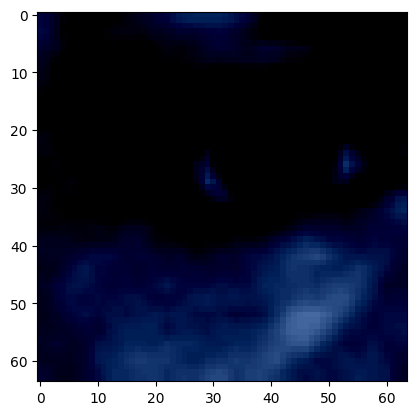

In [94]:
# Visualization
image = img.permute(1,2,0).detach().cpu().numpy()


h,w,_ = image.shape


center_loc = center_loc.detach().cpu().numpy()[0]

# cv2.circle(image,(int(center_loc[0]*RESIZE_AMT),int(center_loc[1]*RESIZE_AMT)),1,(255,0,0),-1)

plt.imshow(image)

In [95]:
# Training 
trainLoader = DataLoader(train_ds, batch_size=2,
	shuffle=True, num_workers=os.cpu_count(), pin_memory=True,drop_last=True)
testLoader = DataLoader(test_ds, batch_size=2,
	num_workers=os.cpu_count(), pin_memory=True,drop_last=True)

: 